# DS 3000 Lab 2

Due: Tuesday May 20 in-class

### Submission Instructions
Upload this `ipynb` file to GitHub, and then to Gradescope.  To ensure that your submitted `ipynb` file represents your latest code, make sure to give a fresh `Kernel > Restart & Run All` just before uploading the `ipynb` file to GitHub and verify that the correct version is represented on Gradescope.

### Tips for success
- Collaborate: bounce ideas off of each other, if you are having trouble you can ask your classmates or Dr. Gerber for help with specific issues, however...
- [(See)](http://www.northeastern.edu/osccr/academic-integrity), i.e. you are welcome to **talk about/discuss** (*not* show or allow each other to copy your answers to) the problems.

In [82]:
# you may want to use the below modules on this lab
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import requests
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
from bs4 import BeautifulSoup
from itertools import zip_longest
import re

# Web Scraping EuroMillions Results

For this problem, we will (together) create a small data set scraped from [Euro-Millions](https://www.euro-millions.com/) which is a lottery that is played across nine European countries. Draws take place on Tuesday and Friday evenings with a minimum guaranteed jackpot of â‚¬17 million.

## Part 1: The Scraper Function (20 points)

Complete the function `get_lottery_html()` below (including docstring) which visits the lottery results for a specific date and grabs the html. Visit [the website](https://www.euro-millions.com/results/) to select a date or two and notice the pattern in the url so that you can pass any date to the function as a string. 

**Make sure to remove the `pass` statement when you are finished**. I have written the code you should run once the function is completed, getting the lottery results from the last day in April.

In [83]:
def get_lottery_html(code):
    """
    returns the html for the euromillions lottery results website for a given date

    Args:
        code(str): A code representing the date

    Returns:
        str_html (str): html string

    """

    url = f'https://www.euro-millions.com/results/{code}'
    str_html = requests.get(url).text
    return str_html


In [84]:
# when you are done the following code should be run
url_text = get_lottery_html('29-04-2025')

## Part 2: The Soup Function (20 points)

Complete the function `get_country_soup()` below (including docstring) which takes the html from the previous function and outputs one of nine beautiful soup objects, depending on the country you are interested in as defined by the `'id'` attribute:

    - `id='PrizeAT'` (Austria)
    - `id='PrizeBE'` (Belgium)
    - `id='PrizeFR'` (France)
    - `id='PrizeIE'` (Ireland)
    - `id='PrizeLU'` (Luxembourg)
    - `id='PrizePT'` (Portugal)
    - `id='PrizeES'` (Spain)
    - `id='PrizeCH'` (Switzerland)
    - `id='PrizeGB'` (UK)
    
The function should take two arguments: the html object from `get_lottery_html()` and a string that specifies the `id` you are interested in (by default, Belgium or `BE`).
    
**Make sure to remove the `pass` statement when you are finished.** Then, also make sure to run the code to ensure your function works.

In [85]:
def get_country_soup(html, country):
    """
    given an html string, creates a bs4 objects depending on the given country

    Args:
        html (str): html string
        country (str): country code as a string

    Returns:
        country_soup (bs4): soup object for the given country

    """
    soup = BeautifulSoup(html)

    country_soup = soup.find(id=f'Prize{country}')
    return country_soup


In [86]:
# when you are done the following code should be run (feel free to change the country if you wish)
country_choice = 'BE'
my_country_soup = get_country_soup(url_text, country_choice)

## Part 3: Cleaning a Country (20 points)

Below is the function `clean_country_df()`, which takes the soup object from the previous function and creates a data frame with the following columns:

    - `balls`: the number of balls matched
    - `stars`: the number of stars matched
    - `ppw`: the prize per winner
    - `country_winners`: how many winners of the prize in the given country
    - `total_winners`: the total number of winners
    - `country`: the country name
    - `currency`: the currency of the lottery

I have written the function and (*given your function from Part 2 works*) it should work. **DO NOT CHANGE ANYTHING IN THE BODY OF THE FUNCTION.**

**In a markdown cell** create a bullet point list where you explain each what each chunk of code does. Your bullet point list should have **THREE** sections, with **NINE** total bullet points/explanations corresponding to the chunks below the `# EXPLAIN THIS (number)` comments. You must accurately summarize the content of each code chunk. **Talking to your neighbors/group about this is highly recommended.**

In [87]:
def clean_country_df(soup, country_name):
    """Takes the soup of a country and cleans it, creating a data frame.
    
    Args:
        soup (soup): the soup from get_country_soup
        country_name (str): name of the country (make sure this matches with the code used in the previous part)
            ** Attention: The country_name must match the country_choice used to create the soup
    Returns:
        clean_country_df (DataFrame): a DataFrame with seven columns corresponding to
            balls matched
            stars matched
            prize per winner
            country winners
            total winners
            country
            currency
    """
    # EXPLAIN THIS (1.1)
    table = soup.find('table')

    # EXPLAIN THIS (1.2)
    headers = [th.get_text(strip=True) for th in table.find('thead').find_all('th')]

    # EXPLAIN THIS (1.3)
    country_winner_index = next((i for i, header in enumerate(headers) if 'Winners' in header and 'Total' not in header), None)

    # EXPLAIN THIS (1.4)
    balls_matched = []
    stars_matched = []
    prize_per_winner = []
    country_winners = []
    total_winners = []
    currencies = []
    
    # Process each row in the table body, excluding the last totals row
    for row in table.find('tbody').find_all('tr')[:-1]:
        columns = row.find_all('td')
        
        # EXPLAIN THIS (2.1)
        numbers_matched = columns[0].get_text(strip=True)
        prize = columns[1].get_text(strip=True)
        country_winner = columns[country_winner_index].get_text(strip=True) if country_winner_index is not None else 'N/A'
        total_winner = columns[-1].get_text(strip=True)
        
        # EXPLAIN THIS (2.2)
        currency_match = re.match(r'^\D*', prize)
        currency = currency_match.group(0) if currency_match else 'N/A'
        currencies.append(currency)
        
        # EXPLAIN THIS (2.3)
        numeric_prize = pd.to_numeric(prize.replace(currency, '').replace(',', ''), errors='coerce')
        
        # EXPLAIN THIS (2.4)
        numbers_split = numbers_matched.split('+')
        balls = pd.to_numeric(numbers_split[0].strip().replace(',', ''), errors='coerce')
        stars = pd.to_numeric(numbers_split[1].strip().replace(',', ''), errors='coerce') if len(numbers_split) > 1 else 0

        balls_matched.append(balls)
        stars_matched.append(stars)
        prize_per_winner.append(numeric_prize)
        country_winners.append(pd.to_numeric(country_winner.replace(',', ''), errors='coerce'))
        total_winners.append(pd.to_numeric(total_winner.replace(',', ''), errors='coerce'))
    
    # EXPLAIN THIS (3)
    data = {
        'balls': balls_matched,
        'stars': stars_matched,
        'ppw': prize_per_winner,
        'country_winners': country_winners,
        'total_winners': total_winners,
        'country': [country_name] * len(balls_matched),
        'currency': currencies
    }
    
    clean_country_df = pd.DataFrame(data)
    
    return clean_country_df

# Example usage
clean_df = clean_country_df(my_country_soup, 'BE')
clean_df

,balls,stars,ppw,country_winners,total_winners,country,currency
0,5,2,83786486.8,0,NaN,BE,€
1,5,1,0.0,0,0.0,BE,€
2,5,0,65420.2,3,11.0,BE,€
3,4,2,1326.9,4,32.0,BE,€
4,4,1,129.2,54,605.0,BE,€
5,3,2,71.5,107,1156.0,BE,€
6,4,0,38.6,107,1502.0,BE,€
7,2,2,17.2,1301,16848.0,BE,€
8,3,1,12.5,1904,25854.0,BE,€
9,3,0,8.9,4780,67339.0,BE,€


Your answer in this cell:
- Explain Code Chunks 1:
    - Extracts the table of information from the Soup object
    - Gets the headers from the table
    - Separates the specific country winners from the total winners
    - creates empty lists for each header in the table
- Explain Code Chunks 2:
    - Populates the numbers, prize, country winners, and total winners for the whole table
    - Adds unique currencies to the list
    - Removes the currency symbol from the winners text
    - converts the balls and stars to numbers
- Explain Code Chunk 3:

    - creates a dictionary that represents the data and then creates a dataframe

## Part 4: Stacking the Countries (20 points)

Complete the function `stack_countries_df()` below (including docstring) which takes as an argument a list of country codes (strings) and a list of dates (strings), and uses the functions from the previous three parts to create a single data frame with results across those countries and dates. There may be multiple ways to do this, but one way could be to first loop through the dates, use the `get_lottery_html()` function, then loop through the countries and apply the other two functions. You will also want to add a column with the date information to the final data frame.

**Make sure to remove the `pass` statement when you are finished.** Then, also make sure to run the code to ensure your function works.

In [88]:
def stack_countries_df(country_list, date_list):
    """
   Constructs a single stacked DataFrame containing lottery results for multiple countries across multiple dates

    Parameters:
        country_list (list of str): A list of country codes to include in the results
        date_list (list of str): A list of dates as strings which are used to retrieve lottery data

    Returns:
        pandas.DataFrame: A concatenated DataFrame with lottery results for all specified countries and dates

    """
    all_data = []

    for date in date_list:
        html = get_lottery_html(date)
        for country in country_list:
            country_soup = get_country_soup(html, country)
            df = clean_country_df(country_soup, country)
            df["date"] = date
            all_data.append(df)

    combined_df = pd.concat(all_data)
    return combined_df



In [89]:
country_codes = ['BE', 'GB', 'CH']
dates = ['25-04-2025', '29-04-2025']
combined_df = stack_countries_df(country_codes, dates)
combined_df

,balls,stars,ppw,country_winners,total_winners,country,currency,date
0,5,2,74400108.10,0,NaN,BE,€,25-04-2025
1,5,1,148333.50,0,5.0,BE,€,25-04-2025
2,5,0,34667.90,0,5.0,BE,€,25-04-2025
3,4,2,1316.80,3,41.0,BE,€,25-04-2025
4,4,1,142.80,82,696.0,BE,€,25-04-2025
...,...,...,...,...,...,...,...,...
8,3,1,26.75,1610,25854.0,CH,CHF,29-04-2025
9,3,0,19.10,4429,67339.0,CH,CHF,29-04-2025
10,1,2,17.50,5542,89036.0,CH,CHF,29-04-2025
11,2,1,13.15,24107,373985.0,CH,CHF,29-04-2025


## Part 5: EDA and Data Viz (20 points)

The first code cell below runs your function from part 4 to get the lottery results for Belgium and France over the month of April 2025. Use this data frame to:

- Create a subset which contains only the 4 ball, 0 star winners
- Plot a line plot that compares the number of 4 ball, 0 star winners for in Belgium and France over April

**Then, in a markdown cell** discuss briefly what this plot tells you, if anything.

In [90]:
country_codes = ['BE', 'FR']
dates = ['01-04-2025', '04-04-2025', '08-04-2025', 
         '11-04-2025', '15-04-2025', '18-04-2025', 
         '22-04-2025', '25-04-2025', '29-04-2025']
combined_df = stack_countries_df(country_codes, dates)

In [91]:
combined_df.tail()

,balls,stars,ppw,country_winners,total_winners,country,currency,date
18,0,NaN,12.4,14325,14325.0,FR,€,29-04-2025
19,2,1.0,6.1,76684,373985.0,FR,€,29-04-2025
20,2,NaN,2.7,37303,37303.0,FR,€,29-04-2025
21,2,0.0,3.8,209656,972679.0,FR,€,29-04-2025
22,0,NaN,2.7,321126,321126.0,FR,€,29-04-2025


In [92]:
subset_4b0s = combined_df[(combined_df['balls'] == 4) & (combined_df['stars'] == 0)]
subset_4b0s

,balls,stars,ppw,country_winners,total_winners,country,currency,date
6,4,0.0,53.2,75,998.0,BE,€,01-04-2025
10,4,0.0,53.2,226,998.0,FR,€,01-04-2025
6,4,0.0,49.2,137,1386.0,BE,€,04-04-2025
10,4,0.0,49.2,259,1386.0,FR,€,04-04-2025
6,4,0.0,56.5,52,858.0,BE,€,08-04-2025
10,4,0.0,56.5,175,858.0,FR,€,08-04-2025
6,4,0.0,49.2,101,1336.0,BE,€,11-04-2025
10,4,0.0,49.2,292,1336.0,FR,€,11-04-2025
6,4,0.0,49.5,58,1042.0,BE,€,15-04-2025
10,4,0.0,49.5,197,1042.0,FR,€,15-04-2025


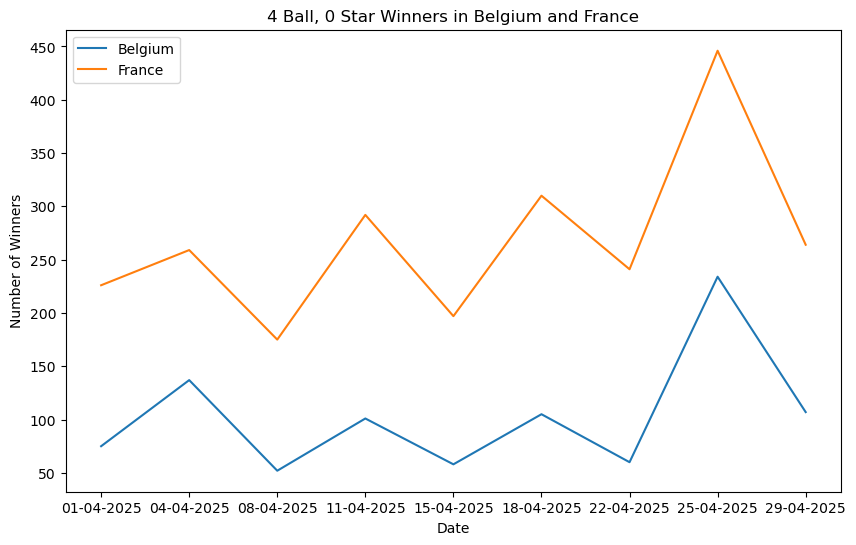

In [93]:
# Create the line plot here (you may use matplotlib or plotly)

plt.figure(figsize=(10, 6))

be_df = subset_4b0s[subset_4b0s['country'] == 'BE']
fr_df = subset_4b0s[subset_4b0s['country'] == 'FR']

plt.plot(be_df['date'], be_df['country_winners'], label='Belgium')
plt.plot(fr_df['date'], fr_df['country_winners'], label='France')

plt.title('4 Ball, 0 Star Winners in Belgium and France')
plt.xlabel('Date')
plt.ylabel('Number of Winners')
plt.legend()
plt.show()


**This plot tells me that for every single lottery draw in the Month of April, there were more 4 Ball, 0 Star lottery winners in France than Belgium**